# Test parameter inference by simulation

This analysis demonstrates fitting utilities of the `afcn` package using simulation data.  The simulations were generated by functions in the `_utils.py` file.

In [2]:
from collections.abc import Iterable
import numpy as np
import matplotlib.pyplot as plt
from afcn import model

import _utils

## Set parameters and generate simulation data

Here we assign our parameters values, number of samples, number of biallelic variants (SNPs), and conduct our simulations.

In [3]:
seed = 42
rng = np.random.default_rng(seed=seed)

n_samples = 1000
j_snps = 5

# assume that parameters are in log2 scale
alpha = 0.4
beta = rng.normal(0, 1.5, size=j_snps)
sd_gene_exp=0.01

maf = _utils.sample_maf(j_snps, 0.05, 0.45, rng=rng)
hap_one, hap_two = _utils.sample_haplotypes(n_samples, maf, rng=rng)

gene_exp = np.zeros(n_samples)

for n in range(n_samples):
    gene_exp[n] = model.simulate(hap_one[n, ],
                                 hap_two[n, ],
                                 alpha, beta, sd_gene_exp,
                                 seed=rng)

/var/folders/qs/byzs5_2s2696wpmmnf9cdzd80000gn/T/ipykernel_91783/849838879.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gene_exp[n] = model.simulate(hap_one[n, ],


Below, and by qualitative inspection, we see that the simulations reproduce the assigned minor allele frequencies.  Moreover, we see that gene expresssion is a skewed distribution, limited to only positive values.

Text(0, 0.5, 'Occurence')

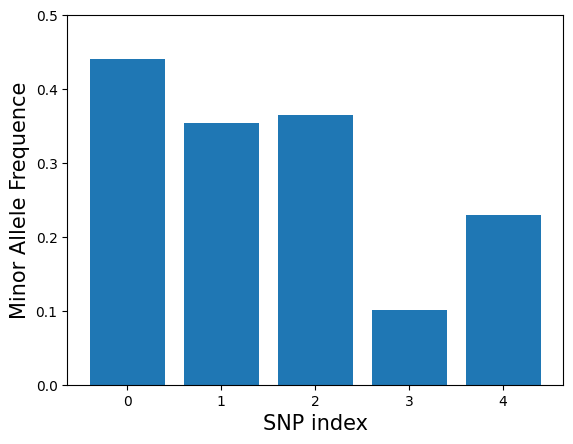

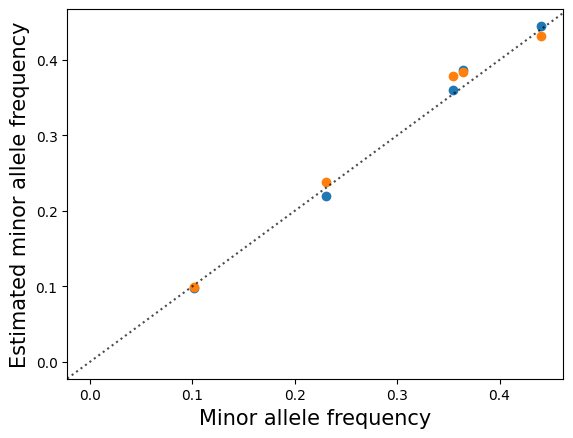

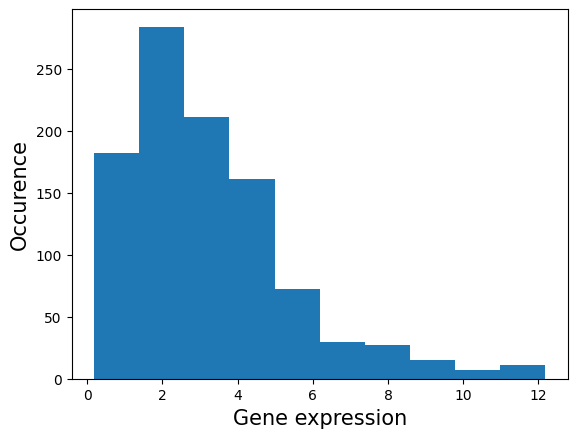

In [3]:
plt.figure()
plt.bar(np.arange(j_snps), maf)
plt.ylim(0, 0.5)
plt.xlabel("SNP index", fontsize=15)
plt.ylabel("Minor Allele Frequence", fontsize=15)

plt.figure()
plt.plot(maf, np.mean(hap_one, 0), "o")
plt.plot(maf, np.mean(hap_two, 0), "o")
plt.axline((0,0), slope=1, linestyle=":", color="k", alpha=0.7)
plt.xlabel("Minor allele frequency", fontsize=15)
plt.ylabel("Estimated minor allele frequency", fontsize=15)

plt.figure()
plt.hist(gene_exp)
plt.xlabel("Gene expression", fontsize=15)
plt.ylabel("Occurence", fontsize=15)

## Linear regression based inference

The model being fit is non-linear, and as such we take a numerical approach.  This leaves the task of picking reasonable initial paramters.  To do this, we developed a linear version of the `afc` model by first order Taylor expansion about parameters = 0.  Below, we see that the linear model estimates effect sizes $\hat{\beta}^{\text{linear}}$ that are close to the true values, but systematically incorrect.

Text(0, 0.5, '$\\hat{\\beta}^{\\text{linear}}$')

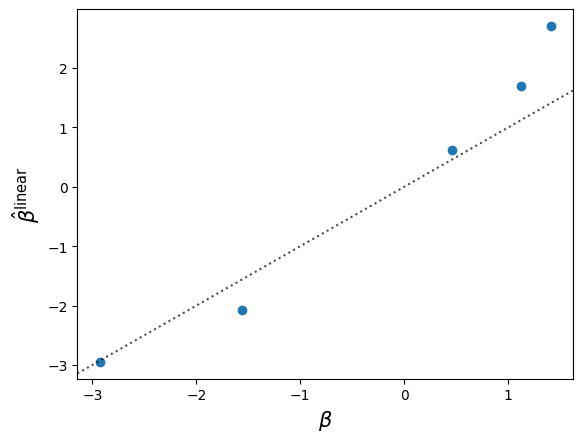

In [9]:
linear_out = model._linear_expansion_model(hap_one, hap_two, gene_exp)

plt.plot(beta, linear_out["pars"][1:], "o")
plt.axline((0,0), slope=1, linestyle=":", color="k", alpha=0.7)
plt.xlabel(r"$\beta$", fontsize=15)
plt.ylabel(r"$\hat{\beta}^{\text{linear}}$", fontsize=15)

## Non linear fit

The non-linear model was fit by Newton-CG as implemented in `scipy.optimize.minimize`.  Below, we see that the inferred effect-sizes, $\hat{\beta}^\text{nonlinear}$ reproduce the true values.

In [6]:
nonlin_out = model.fit(hap_one, hap_two, gene_exp)
nonlin_out

     message: Optimization terminated successfully.
     success: True
      status: 0
         fun: 0.07269783956046437
           x: [ 3.992e-01  4.585e-01 -1.560e+00  1.125e+00  1.413e+00
               -2.929e+00]
         nit: 9
         jac: [ 2.718e-04  1.765e-04 -1.557e-03  8.587e-06 -5.495e-05
                7.240e-05]
        nfev: 10
        njev: 43
        nhev: 0
 matrix_rank: 6

Text(0, 0.5, '$\\hat{\\beta}^{\\text{nonlinear}}$')

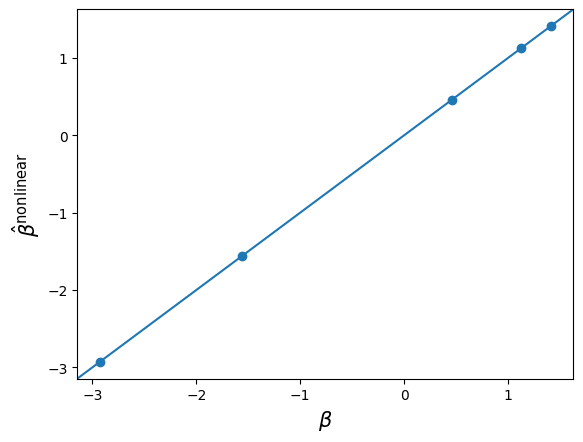

In [11]:
plt.plot(beta, nonlin_out["x"][1:], 'o')
plt.axline((0,0), slope=1, linestyle=":", color="k", alpha=0.7)
plt.xlabel(r'$\beta$', fontsize=15)
plt.ylabel(r"$\hat{\beta}^{\text{nonlinear}}$", fontsize=15)